In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time
import pyfeltor.dg as dg

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
data = simplesim.Manager( directory="./resistivity-new-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="./resistivity-new-diag", filetype="nc")
outfiles = simplesim.Manager( directory = "./resistivity-new-data", filetype="out" )

In [3]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [4]:
# # This cell may take a minute ...
# print( "content")
# content = data.table()
# content = sorted(content, key=lambda pp: (pp['grid']['n'], pp['physical']['tau']),reverse=True)
# for pp in content : # modifying pp modifies content
#     print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
#     file = create_merged_dataset( data, pp)
#     pp['file'] = file
print( "content")
contentdiag = diag.table()
contentdiag = sorted(contentdiag, key=lambda pp: (pp['grid']['n'], pp['physical']['tau']),reverse=True)
for pp in contentdiag : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file


content
3e-06 1 3 [2, 2]
0.0001 1 3 [2, 2]
0.0003 1 3 [2, 2]
3e-05 1 3 [2, 2]
1e-05 1 3 [2, 2]
1e-06 1 3 [2, 2]
1e-05 0 3 [2, 2]
3e-06 0 3 [2, 2]
0.0001 0 3 [2, 2]
3e-05 0 3 [2, 2]
1e-06 0 3 [2, 2]
0.0003 0 3 [2, 2]


In [5]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in contentdiag : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['dvdpsi'] = da0['dvdpsi'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])# lcfs index
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]
    

3e-06 1
0.0001 1
0.0003 1
3e-05 1
1e-05 1
1e-06 1
1e-05 0
3e-06 0
0.0001 0
3e-05 0
1e-06 0
0.0003 0


In [6]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in contentdiag :
    if pp['physical']['resistivity'] == 1e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [7]:
min_idx_dict = {
    0 : {1e-6: 300, 1e-4 : 250 , 1e-5 : 300, 3e-6: 300, 3e-5 : 300, 3e-4: 150},
    1 : {1e-6: 200, 1e-4 : 200 , 1e-5 : 200, 3e-6: 200, 3e-5 : 300, 3e-4: 150}          
} # in cs/R0

In [8]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8" #change color 6,which is red
# "#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
#  "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"
'C0','C1','C2','C4','C5','C6','C7','C8','C9'    
]

In [9]:
content = contentdiag

### Some thoughts on why Div formulation of FSAs may be better than currents

We should understand that
\begin{align}
F(\psi_p) := \langle f\rangle
\end{align}
is computed by evaluating a (numerically computed) function on a one-dimensional dG grid (the $\psi_p$ grid).
It is likely that the individual elements $F_i$ have errors $F_i\pm \varepsilon_i$. Maybe Computing derivatives 
\begin{align}
 \frac{\partial F}{\partial v}
 \end{align}
is difficult because we do not know in which dG derivative $F$ converged, so a dG derivative may introduce oscillations. Also evaluating $F$ at the LCFS (or on any cell boundary in general) is problematic because dG is not ambiguous on boundaries; probably using dG also has an extrapolation error and very much depends on the errors in the last cell.
(If this was true it would be necessary to compute 
\begin{align}
 \langle \vec j \cdot \nabla v\rangle|_{LCFS}
\end{align}
directly on the LCFS without using an extrapolation formula)



Computing integrals 
\begin{align}
\int dv \langle f\rangle 
\end{align}
is likely more precise because in our framework since this becomes Gauss-Legendre integration especially if we integrate up to a cell boundary and in particular the LCFS (which is a cell-boundary). Since the flux-surface average itself is computed via
\begin{align}
F(\psi_p) = (d v/ d \psi_p)^{-1} \int d \eta  \sqrt{G} f(\zeta,\eta)
\end{align}
the volume integral is equivalent to computing directly in the $\zeta$, $\eta$ grid
\begin{align}
\int dv F = \int d \zeta d\eta \sqrt{G} f(\zeta,\eta)
\end{align}
i.e. the only error is in the interpolation from $f(R,Z)$ to $f(\zeta,\eta)$.


In [10]:
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x
def errorToString(x):
    return '%.2e' % x
def intToString(x):
    return '%02d' % x

In [11]:
filelist = diag.table()
filelist = sorted( filelist , key=lambda d: (d['physical']['tau'], d['physical']['resistivity']))
for pp in filelist:    
    print( diag.outfile( pp), " split into ", diag.count( pp), " file(s)",
          "tau", pp["physical"]["tau"], "res", pp["physical"]["resistivity"])

to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
}
for pp in content :
    da = pp['file']
    time_ = np.asarray(da['time'][:])
    deltat = np.diff(np.append(time_, 2*time_[-1] -time_[-2]))
    tau = pp["physical"]["tau"]
    res = pp["physical"]["resistivity"]
    to_plot["res"][tau].append(res)
    to_plot["times"][tau][res] = time_
    to_plot["params"][tau][res] = pp 
# Create simulation times table
datalist=list()
columns=[r"$\eta$",'a', 'b', 'c', 'd']

for res in to_plot['res'][0]:
    line = list()
    line.append(res)
    for tau in to_plot['tau'] :
        timescale = fp.omega_0_inv(**to_plot["params"][tau][res]['physical'])*1e3 # in ms
        line.append( to_plot['times'][tau][res][-1])
        line.append( to_plot['times'][tau][res][-1]*timescale)
        
        #print( tau, res, to_plot['times'][tau][res][-1], to_plot['times'][tau][res][-1]*timescale)
    datalist.append(line)
df = pd.DataFrame( datalist, columns=columns) 
df.sort_values( by = r'$\eta$', inplace=True)
df_str = df
for header in ["$\eta$"] :  
    df_str[header] = df_str[header].apply( errorToString)
for header in ['a', 'c'] :  
    df_str[header] = df_str[header].apply( intToString)
for header in ['b', 'd'] :  
    df_str[header] = df_str[header].apply( orderToString)
df_str.set_index("$\eta$", inplace=True)

columns = [(r"$\tau=0$", r"$T_\mathrm{end}/\Omega_0^{-1}$"), (r"$\tau=0$",r"$T_\mathrm{end}/$ms"),
                (r"$\tau=1$", r"$T_\mathrm{end}/\Omega_0^{-1}$"), (r"$\tau=1$",r"$T_\mathrm{end}/$ms" )]
df.columns=pd.MultiIndex.from_tuples(columns)

filename = "endtimes.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rrrrr', hrules=True),'UTF-8'))
    

df_str


./resistivity-new-diag/e8025de1880299210c2ceeb01db51e00ac9d8087.nc  split into  7  file(s) tau 0 res 1e-06
./resistivity-new-diag/5a1869d7ed70394c1bd05e9c610623517269179d.nc  split into  7  file(s) tau 0 res 3e-06
./resistivity-new-diag/1f1ab687243422011a4b80ed9684a5e0cd49477a.nc  split into  7  file(s) tau 0 res 1e-05
./resistivity-new-diag/d7fc0440a0efb4ff396e056b90b99ec29c1b194e.nc  split into  10  file(s) tau 0 res 3e-05
./resistivity-new-diag/7f852ba3d56765383228e963268ee9593583c96e.nc  split into  9  file(s) tau 0 res 0.0001
./resistivity-new-diag/fcc094a5a840a5bc898a012a88a3e8856e94d95c.nc  split into  10  file(s) tau 0 res 0.0003
./resistivity-new-diag/de43b2cf5c7d901c011784b15a4e5d9702808f66.nc  split into  7  file(s) tau 1 res 1e-06
./resistivity-new-diag/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.nc  split into  7  file(s) tau 1 res 3e-06
./resistivity-new-diag/bb9743ce9505b22bf7474671f3ecef8a340e83bf.nc  split into  7  file(s) tau 1 res 1e-05
./resistivity-new-diag/a9c2c59b90

$\tau=0$                      \
         $T_\mathrm{end}/\Omega_0^{-1}$ $T_\mathrm{end}/$ms   
$\eta$                                                        
1.00e-06                         110400                1.81   
3.00e-06                         110200                2.38   
1.00e-05                          97500                2.84   
3.00e-05                         100000                3.83   
1.00e-04                          89100                4.62   
3.00e-04                         100000                6.82   

                               $\tau=1$                      
         $T_\mathrm{end}/\Omega_0^{-1}$ $T_\mathrm{end}/$ms  
$\eta$                                                       
1.00e-06                         111600                1.83  
3.00e-06                         111200                2.40  
1.00e-05                          88800                2.59  
3.00e-05                         100000                3.83  
1.00e-04                         100000                5.18  
3.00e-04                          99800                6.80

./resistivity-new-data/e8025de1880299210c2ceeb01db51e00ac9d8087.out 0 1e-06
5.3±0.7


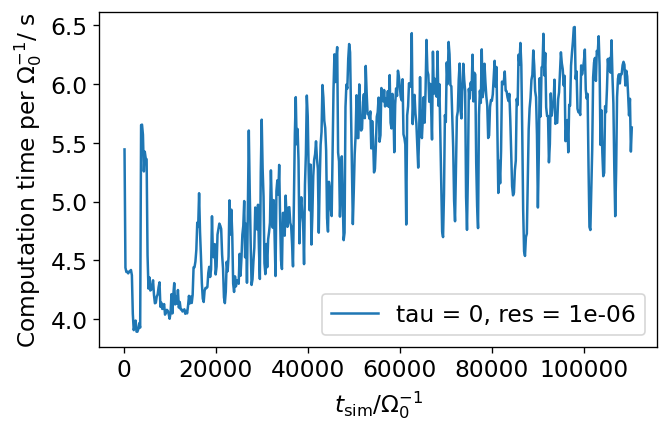

./resistivity-new-data/5a1869d7ed70394c1bd05e9c610623517269179d.out 0 3e-06
5.3±0.8


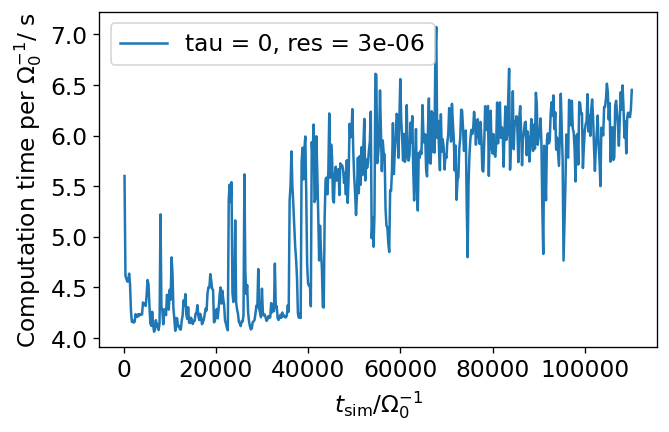

./resistivity-new-data/1f1ab687243422011a4b80ed9684a5e0cd49477a.out 0 1e-05
5.6±1.0


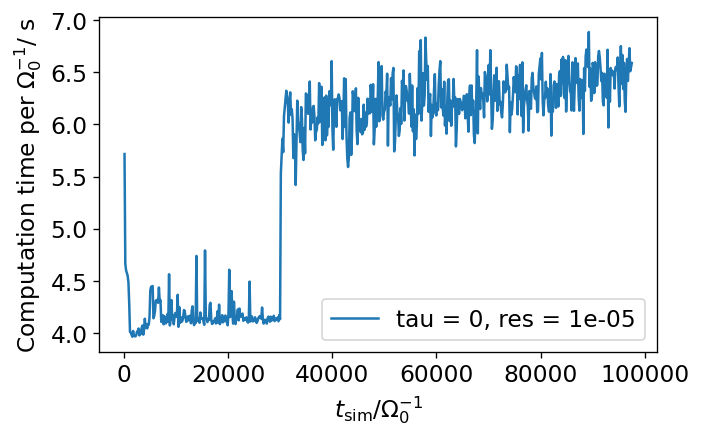

./resistivity-new-data/d7fc0440a0efb4ff396e056b90b99ec29c1b194e.out 0 3e-05
7.2±0.2


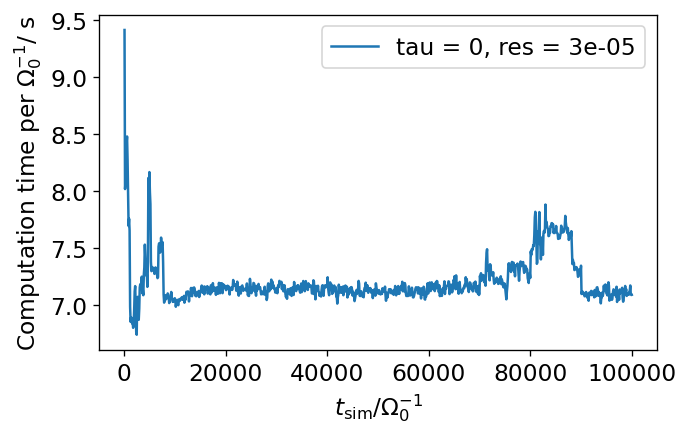

./resistivity-new-data/7f852ba3d56765383228e963268ee9593583c96e.out 0 0.0001
4.6±0.6


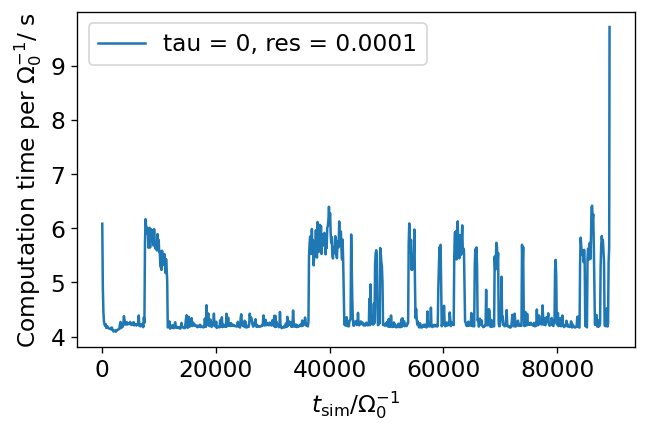

./resistivity-new-data/fcc094a5a840a5bc898a012a88a3e8856e94d95c.out 0 0.0003
6.1±0.4


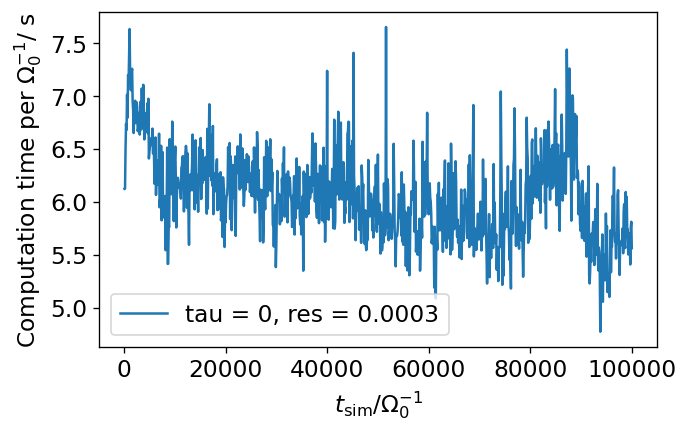

./resistivity-new-data/de43b2cf5c7d901c011784b15a4e5d9702808f66.out 1 1e-06
5.3±0.2


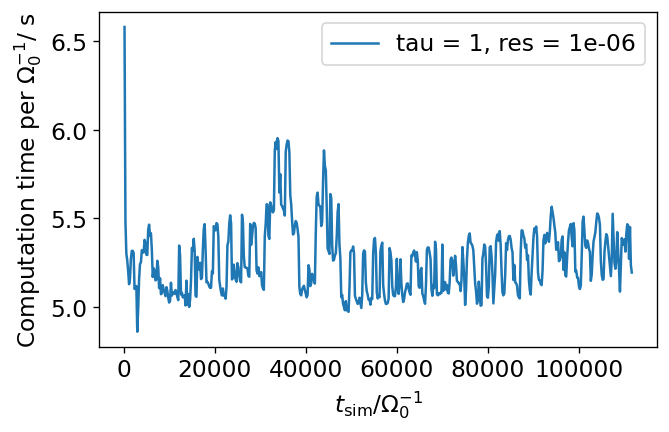

./resistivity-new-data/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.out 1 3e-06
5.3±0.2


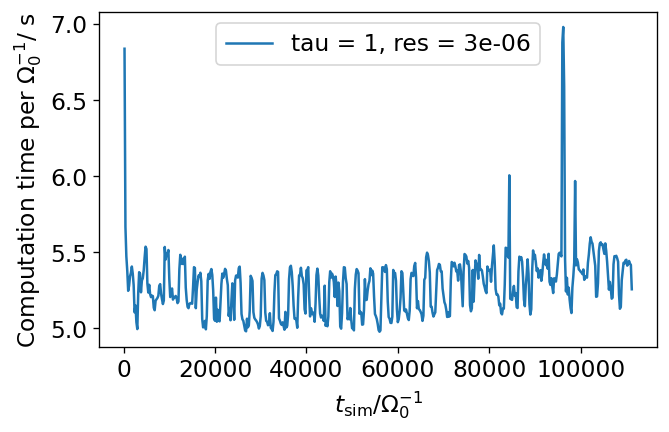

./resistivity-new-data/c401bf96128983c2d27ca0212aff462e865274a3.out 1 1e-05
7.0±0.9


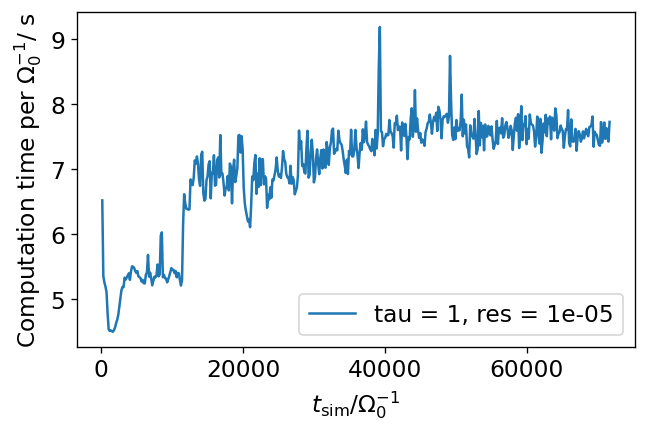

./resistivity-new-data/c401bf96128983c2d27ca0212aff462e865274a3.out 1 1e-05
7.0±0.9


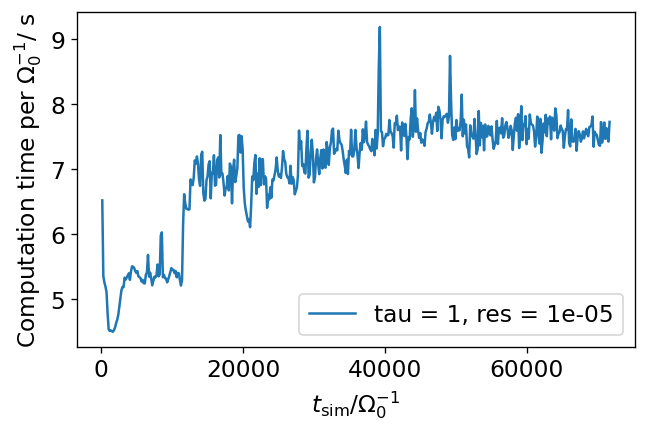

./resistivity-new-data/a9c2c59b90af00fe9a0ecc143e930168a528f06e.out 1 3e-05
7.4±0.6


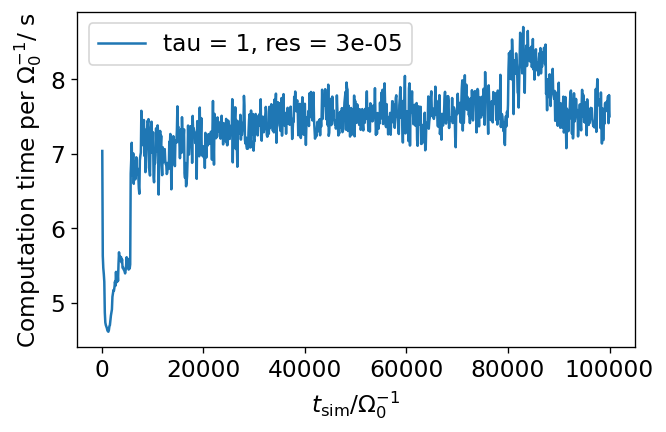

./resistivity-new-data/3ec81972a93bd5b7efb96fff8f32a128e879b6ea.out 1 0.0001
5.4±0.4


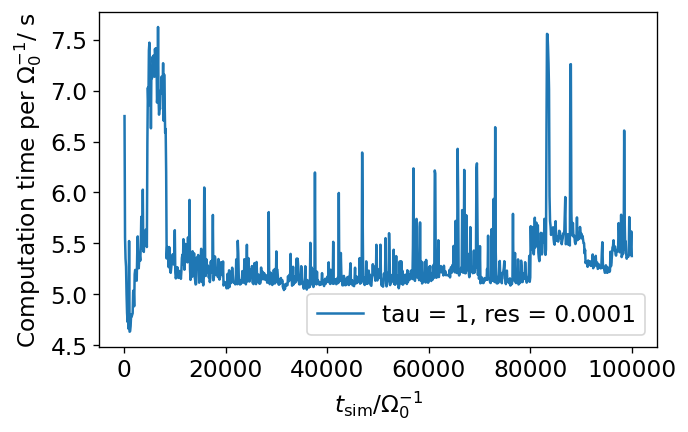

./resistivity-new-data/8ff727a75b374aeb38e1093af32542ef213cc1fe.out 1 0.0003
8.3±0.2


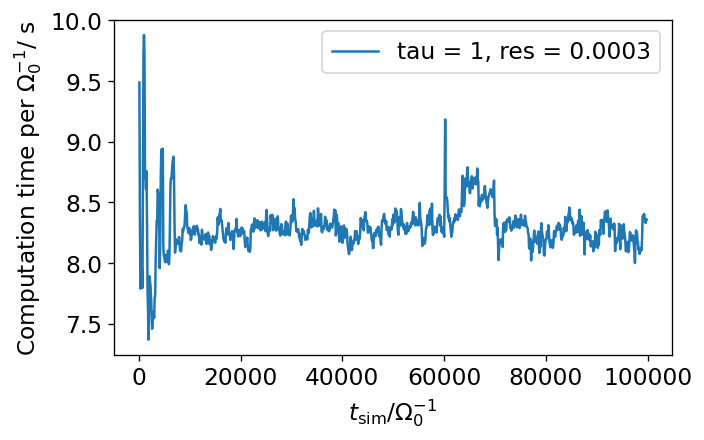

In [12]:
# Let's try to parse the out files from the simulations
import re 
filelist = outfiles.table()
filelist = sorted( filelist , key=lambda d: (d['physical']['tau'], d['physical']['resistivity']))
# for pp in filelist:
#     for i in range(0, outfiles.count(pp)):
#         print( outfiles.outfile( pp,i  ))
to_plot = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "avg_time": {0:dict(),1:dict()},
    "std_time": {0:dict(), 1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
}
for pp in filelist:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    tau = pp["physical"]["tau"]
    res = pp["physical"]["resistivity"]
   
    print( outfiles.outfile( pp ), tau , res)
    times = list()
    timings = list()
    for i in range(0, outfiles.count( pp)):        
        
        with open (outfiles.outfile( pp,i  ) ) as file:
            for line in file:
                if "Step: Time " in line:
                    times.append( int(re.findall(r'\d+', line)[0]))
                if "Average time for one inner loop: " in line:
# https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python
                    timings.append( float(re.findall(r'[\d]*[.][\d]+', line)[0]
                                         )/pp["timestepper"]["deltaT"]*pp["output"]["itstp"])
    print( f"{np.mean(timings):.1f}"+u"\u00B1"+f"{np.std(timings):.1f}")
    to_plot["res"][tau].append(res)
    to_plot["avg_time"][tau][res] = np.mean(timings)
    to_plot["std_time"][tau][res] = np.std(timings)
    to_plot["params"][tau][res] = pp 
#     print( timings)
    ax.plot( times, timings, label = f"tau = {tau}, res = {res}")
    ax.set_xlabel(r"$t_\mathrm{sim}/ \Omega_0^{-1}$" )
    ax.set_ylabel(r"Computation time per $\Omega_0^{-1}$/ s" )
    plt.legend()
    plt.show()

In [13]:

# Create simulation times table
datalist=list()
columns=[r"$\eta$",r"$\tau=0$", r"$\tau=1$"]

for res in to_plot['res'][0]:
    line = list()
    line.append(res)
    for tau in to_plot['tau'] :
        line.append( f"{to_plot['avg_time'][tau][res]:.1f} "  + u"\u00B1"+ 
                    f" {to_plot['std_time'][tau][res]:.1f}")
    datalist.append(line)
df = pd.DataFrame( datalist, columns=columns) 
df.sort_values( by = r'$\eta$', inplace=True)
df_str = df
for header in ["$\eta$"] :  
    df_str[header] = df_str[header].apply( errorToString)
df_str.set_index("$\eta$", inplace=True)

# df.columns=pd.MultiIndex.from_tuples(columns)

filename = "timings.tex"
with open(filename, 'wb') as f:
    f.write(bytes(df_str.style.to_latex(
        column_format='rrr', hrules=True),'UTF-8'))
    

df_str

,$\tau=0$,$\tau=1$
$\eta$,,
1.00e-06,5.3 ± 0.7,5.3 ± 0.2
3.00e-06,5.3 ± 0.8,5.3 ± 0.2
1.00e-05,5.6 ± 1.0,7.0 ± 0.9
3.00e-05,7.2 ± 0.2,7.4 ± 0.6
1.00e-04,4.6 ± 0.6,5.4 ± 0.4
3.00e-04,6.1 ± 0.4,8.3 ± 0.2


In [14]:
# print(len( content[0]['file'])/3)
# content[0]['file']['TEST_fsa'] = content[0]["file"]['psi_fsa']
# for item in content[0]['file']:
#     if '_fsa' in item :
#         print(item)

In [17]:
# fsa_params = content[0]["output"]["fsa"]
# psi = content[0]["file"]["psi"]
# # THIS TAKES A LONG TIME, PROBABLY FASTER TO DO IT INPLACE WHEN NEEDED
# grid = dg.create.grid_from_abscissas( [psi])
# for item in content[0]['file']:
#     if '_fsa' in item :
#         print(item)
#         ifs = item.replace('_fsa', '_ifs')
#         if ifs not in content[0]['file']:
#             content[0]['file'][ifs] = content[0]['file'][item]
#             for i in range(0,content[0]['file'][item].shape[0]):
#                 content[0]['file'][ifs] = dg.integrate(
#                     (content[0]['file'][item][:,:]*content[0]['dvdpsi'][None,:]).to_numpy(),grid)
#             print(ifs)
        

In [18]:
# # This works reasonably fast

# for pp in contentdiag:
#     print( pp['physical']['resistivity'], pp['physical']['tau'])
#     grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
#     weights = dg.create.weights( grid)*pp['dvdpsi'][:]
#     lcfs_idx = pp["lcfs"]
#     for item in pp['file']:
#         if '_fsa' in item :
#             ifs_lcfs = item.replace('_fsa', '_ifs_lcfs')
# #             if ifs_lcfs not in pp['file']:
#             pp[ifs_lcfs] = np.sum(
#                 pp['file'][item][:,:lcfs_idx+1]*weights[None,:lcfs_idx+1], axis=1)

In [19]:
# fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')

# ax.plot( content[0]["rho"][0:168], content[0]['file']["divneE_tt_fsa"][-1,0:168]
#         ,  label='data')
# ax.plot( contentdiag[0]["rho"][0:168], contentdiag[0]['file']["divneE_tt_fsa"][-1,0:168]
#         ,  label='diag')
# plt.xlim([0.,1])
# plt.legend()
# plt.show()

In [20]:
# fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
# pp = contentdiag[0]
# ax.plot( pp['file']['time'], pp['file']['divneE_tt_ifs_lcfs'][:],label='divjE ')
# ax.plot( pp['file']['time'], pp['divneE_tt_ifs_lcfs'][:],  label='jE')

# plt.legend()
# plt.show()

The results of compressing the field before the FSA is slightly different. (It slightly smoothes oscillations)

Maybe plot all div quantities to check for oscillations

In [21]:
# # Let's plot a few test

# # 'divee_tt_ifs_lcfs','divei_tt_ifs_lcfs','diveea_tt_ifs_lcfs','diveia_tt_ifs_lcfs'
# for pp in content:
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
#     ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
#                                          -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
#             label='divjE ')
#     ax.plot( pp['rho_p'], (pp['file']['jsneE_tt_fsa'][-1,:]-pp['file']['jsniE_tt_fsa'][-1,:])*pp['dvdpsi'],
#             label='jE ')

#     plt.legend()
#     plt.show()

Computing the FSA using the js* formulas is prone to oscillations for some reason

In [22]:
# # Let's plot a few test
# for pp in contentdiag:
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
#     ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
#                                          -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
#             label='divjE ')
#     ax.plot( pp['rho_p'], (pp['file']['jvneE_tt_fsa'][-1,:]-pp['file']['jvniE_tt_fsa'][-1,:]),
#             label='jE ')

#     plt.legend()
#     plt.show()

In [23]:
# # Let's plot a few test
# for pp in content:
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
#     ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divcurvne_tt_fsa'][-1,:]
#                                          -pp['file']['divcurvni_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
#             label='divjC ')
#     ax.plot( pp['rho_p'], (pp['file']['jscurvne_tt_fsa'][-1,:]-
#                            pp['file']['jscurvni_tt_fsa'][-1,:])*pp['dvdpsi'],
#             label='jC')

#     plt.legend()
#     plt.show()

Depending on how exactly we compute the flux surface average we obtain different results

The problem is also the derivative of the FSA

This will generate problems when comparing quantities on the LCFS

In [24]:
# # PLOT EVERYTHING to visually check for oscillations
# for item in content[0]['file']:
#     da = content[0]['file']
#     if not '_fsa' in item and not '_2d' in item and not '_lcfs' in item:
#         if len(da[item].shape) == 3 :
# #         print(item)
#             fig,ax=plt.subplots(1,2,figsize=(2*4,2),dpi= 90, facecolor='w', edgecolor='k')
#             pcm = ax[0].pcolormesh( da['x'][200:], da['y'][250:300],
#                     da[item][-1,250:300,200:],#vmin=-5,vmax=5,
#                 shading='gouraud',
#                 cmap="seismic",
#               rasterized=True)
#             ax[0].set_aspect('equal')
#             ax[0].set_xlabel( r"$R/\rho_s$")
#             ax[0].set_ylabel( r"$Z/\rho_s$")
#             ax[0].set_title( item)
#             if '_ta2d' in item :
#                 ax[1].plot( da['rho_p'][-1,:], da[item.replace('_ta2d', '_fsa')][-1,:] )
#             ax[1].set_xlabel(r"$\rho_p$")
# #             ax[1].set_aspect(0.5)
#     #         im = ax.contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
#     #                         levels=[1], linewidths=2,colors='k')
#             plt.show()

In [25]:
# da = Dataset( data.outfile(data.table()[0]),'r')
# fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')

# # cmap=plt.get_cmap('twilight_shifted')
# pcm = ax[0].pcolormesh( da['x'][200:], da['y'][250:300],
#                     da['divniE_tt_2d'][-1,250:300,200:],
#                        vmin=-1,vmax=1,
#                 shading='gouraud',
#                 cmap="seismic",
#               rasterized=True)
# ax[0].set_aspect('equal')
# ax[0].set_xlabel( r"$R/\rho_s$")
# ax[0].set_ylabel( r"$Z/\rho_s$")
# ax[0].set_title( r"$\nabla \cdot( N_i u_E^i)$")
# im = ax[0].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
#                 levels=[1], linewidths=2,colors='k')
# pcm = ax[1].pcolormesh( da['x'][200:], da['y'][250:300],
#                     da['jsniE_tt_2d'][-1,250:300,200:],vmin=-5,vmax=5,
#                 shading='gouraud',
#                 cmap="seismic",
#               rasterized=True)
# ax[1].set_aspect('equal')
# ax[1].set_xlabel( r"$R/\rho_s$")
# ax[1].set_ylabel( r"$Z/\rho_s$")
# ax[1].set_title( r"$N_i u_E^i\cdot \nabla\psi_p$")
# im = ax[1].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
#                 levels=[1], linewidths=2,colors='k')
# # plt.savefig( 'jsni_2d.png',bbox_inches='tight')
# plt.show()

In [26]:
# da = Dataset( data.outfile(data.table()[0]),'r')
# fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')
# # cmap=plt.get_cmap('twilight_shifted')
# pcm = ax[0].pcolormesh( da['x'][200:], da['y'][250:300],
#                     da['electrons_2d'][-1,250:300,200:]-da['gammaNi_2d'][-1,250:300,200:],
#                        vmin=-0.3,vmax=0.3,
#                 shading='gouraud',
#                 cmap="seismic",
#               rasterized=True)
# im = ax[0].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
#                 levels=[1], linewidths=2,colors='k')
# ax[0].set_aspect('equal')
# ax[0].set_xlabel( r"$R/\rho_s$")
# ax[0].set_ylabel( r"$Z/\rho_s$")
# ax[0].set_title(r"$n_e - N_i$")
# pcm = ax[1].pcolormesh( da['x'][200:], da['y'][250:300],
#                     da['v_Omega_E_gf_2d'][-1,250:300,200:],vmin=-0.3,vmax=0.3,
#                 shading='gouraud',
#                 cmap="seismic",
#               rasterized=True)
# ax[1].set_aspect('equal')
# ax[1].set_xlabel( r"$R/\rho_s$")
# ax[1].set_ylabel( r"$Z/\rho_s$")
# ax[1].set_title(r"$\nabla\cdot ( N_i \nabla_\perp \phi/B^2)$ centered derivatives")
# im = ax[1].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
#                 levels=[1], linewidths=2,colors='k')
# # plt.savefig( 'centered-derivative-elliptic-2d.png',bbox_inches='tight')
# plt.show()

In [27]:
# rhs = da['electrons_2d'][-1,:,:]-da['gammaNi_2d'][-1,:,:]
# error = (rhs -  da['v_Omega_E_gf_2d'][-1,:,:])
# norm_error = np.sqrt(np.sum( error*da['vol2d']*error))
# norm_b = np.sqrt(np.sum( rhs*da['vol2d']*rhs))
# print(f"Relative error {norm_error/norm_b:0.2f}")

In [28]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau, style):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
    std = dict()
    
    yscale = to_plot["yscale"][0](to_plot["params"][tau][res]['physical'])

    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
        std[field["label"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
            std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = list()
    mean_error = np.zeros(size)
    std_error = np.zeros(size)
    for i in np.arange(0,size,1):   
        min_idx = min_idx_dict[tau][resistivities[i]]
        error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
        for field in to_plot["fields"]:
            error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
        mean_error[i] = error[i].mean()
        std_error[i] = error[i].std()

    summe_ohne_fehler = np.zeros(size)
    summe = np.abs(mean_error)
    for field in to_plot["fields"]:
        summe_ohne_fehler += np.abs(mean[field["label"]])
        summe = summe + np.abs(mean[field["label"]])
    if style == "log":
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
#                 ax.fill_between(resistivities, np.abs(mean[field["label"]])/summe,
#                                 (np.abs(mean[field["label"]])+std[field["label"]])/summe,
#                                 color = colors[field["color"]], alpha=0.1)
        ax.plot( resistivities, np.abs(mean_error)/summe,
                marker='x', ls='--',label="Error",  color = "r"
               )
#         ax.fill_between(resistivities, np.abs(mean_error)/summe,
#                 (np.abs(mean_error)+std_error)/summe,
#                 color ="r", alpha=0.1)
        ax.set_ylabel('relative importance')  
        ax.set_yscale('log')
    if style == "symlog":
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
#                 print( field["label"], mean[field["label"]],
#                       mean_error*np.abs(mean[field["label"]])/summe_ohne_fehler)
                ax.plot( resistivities, mean[field["label"]]*yscale,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, (mean[field["label"]]-
                                mean_error*np.abs(mean[field["label"]])/summe_ohne_fehler)*yscale,
                                mean[field["label"]]*yscale,
                                color = colors[field["color"]], alpha=0.1)
#         ax.plot( resistivities, mean_error,
#                 marker='x', ls='--',label="Error",  color = "r"
#                )
#         ax.fill_between(resistivities, np.abs(mean_error)/summe,
#                 (np.abs(mean_error)+std_error)/summe,
#                 color ="r", alpha=0.1)
        ax.set_ylabel(
            r'$T_i^\mathrm{num}$ / '+
#             r'$\frac{1}{\Delta t}\int_{t_0}^{t_1}\int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv dt$ / '+
                      to_plot["yscale"][1]) 
        ax.set_yscale('symlog')
    elif style == 'linear':

        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, mean[field["label"]]/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, (mean[field["label"]]-std[field["label"]])/summe,
                                (mean[field["label"]]+std[field["label"]])/summe,
                                color = colors[field["color"]],
                        alpha=0.2)
        ax.plot( resistivities, mean_error/summe,
                marker='x', ls='--',label="Error",  color = "r"  )
        ax.fill_between(resistivities, (mean_error-std_error)/summe, (mean_error+std_error)/summe,
                        color='r', alpha=0.1)
        low, high = ax.get_ylim()
        # find the new limits
        bound = max(abs(low), abs(high))
        # set new limits
        ax.set_ylim(-bound, bound)  
        ax.set_ylabel('relative importance')    
            
    ax.set_xlabel(r'$\eta$')
    
    ax.set_xscale('log')    

In [29]:
def plot_series( to_plot, ax, tau, res, start_idx=1):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
    std = dict()
    min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][min_idx:].mean()
        std[field["label"]]  = field["vals"][tau][res][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[min_idx:].mean()
    std_error = error[min_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)
    ####################### TIMESCALE
    timescale = to_plot["timescale"][0](to_plot["params"][tau][res]['physical'])
    yscale = to_plot["yscale"][0](to_plot["params"][tau][res]['physical'])

    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][start_idx:]*timescale, field["vals"][tau][res][start_idx:]*yscale,
            ls='-',label=field["label"]
                , color = colors[field["color"]]
               )
#         ax.hlines(mean[field['label']], to_plot["times"][tau][res][min_idx],
#                   to_plot["times"][tau][res][-1], color=colors[field["color"]])
        ax.fill_between( to_plot["times"][tau][res][min_idx:]*timescale,
                        (mean[field['label']]-std[field['label']])*yscale,
                        (mean[field['label']]+std[field['label']])*yscale,
                        color=colors[field["color"]], alpha=0.2)
    
    ax.plot( to_plot["times"][tau][res][start_idx:]*timescale, error[start_idx:]*yscale,
            ls='--',label="Error",  color = "r"
           )
#     ax.hlines(mean_error, to_plot["times"][tau][res][min_idx],
#               to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][min_idx:]*timescale,
                    (mean_error-std_error)*yscale, (mean_error+std_error)*yscale,
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / '+to_plot["timescale"][1])
    ax.set_ylabel(r'$\int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv$ / '+to_plot["yscale"][1])
    # get y-axis limits of the plot
    low, high = ax.get_ylim()
    # find the new limits
    bound = max(abs(low), abs(high))
    # set new limits
    ax.set_ylim(-bound, bound)

In [30]:
def make_to_plot( to_plot, in_content):
    """Fill in values in the to_plot dictionary"""
    for pp in in_content :
        da = pp['file']
        time_ = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time_, 2*time_[-1] -time_[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time_
        to_plot["params"][tau][res] = pp 
        for field in to_plot["fields"]:
            series = np.zeros(len(time_))
            for (name,sign,derive) in zip(field["names"],field["signs"],field['derive']):
                addition = np.zeros(len(time_))
#                 print(field)
                if "idx" in field.keys():
                    addition = da[name][:,field["idx"]].to_numpy()*sign
                else:
                    addition = da[name][:].to_numpy()*sign
                if derive:
                    addition = np.diff(np.append(np.zeros(1),addition, axis=0))/deltat
                else:
                    addition = addition/deltat
                series = series + addition
            field["vals"][tau][res] = series

In [31]:
def milliseconds( params):
    return fp.omega_0_inv(**params)*1e3 # in ms
def omegaci( params):
    return 1
def density(params):
    return 1./fp.omega_0_inv(**params)*fp.rho_s(**params)**3*1e19/1e3

In [32]:
### THE TERMS IN THE MASS CONSERVATION
to_plot_ne = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds, "ms"],
    "yscale" : [density, " ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divneE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divcurvne_tt_ifs_lcfs','divcurvkappane_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
        "names" : ['divneA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 3,
        "label" :  r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "color": 4,
#         "label" :  r"$\nabla \cdot \vec{ j_\parallel}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['lneperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 5,
        "label" :  r"$-\Lambda_{n_e,\perp}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "color": 6,
#         "label" :  r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sne_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "names" : ['sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 7,
        "label" :  r"$-S_{n_e}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot_ne, content)

Mean error is  -41.2643787784682  std error is  26.937873299898282


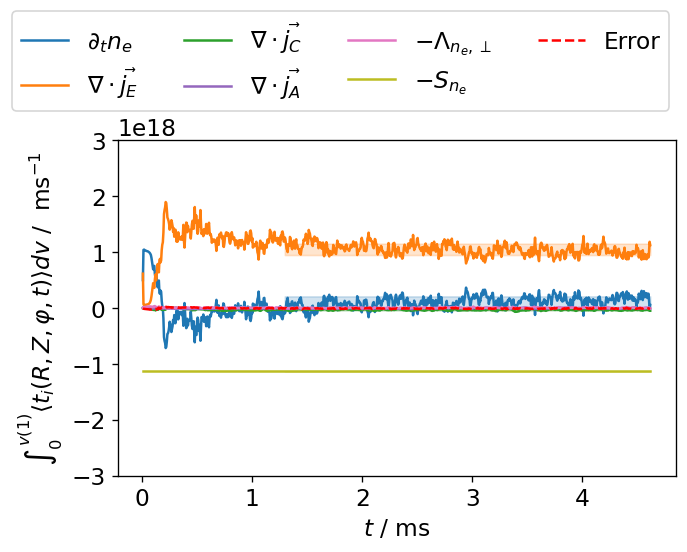

Mean error is  -131.71096060210536  std error is  26.64415446866561


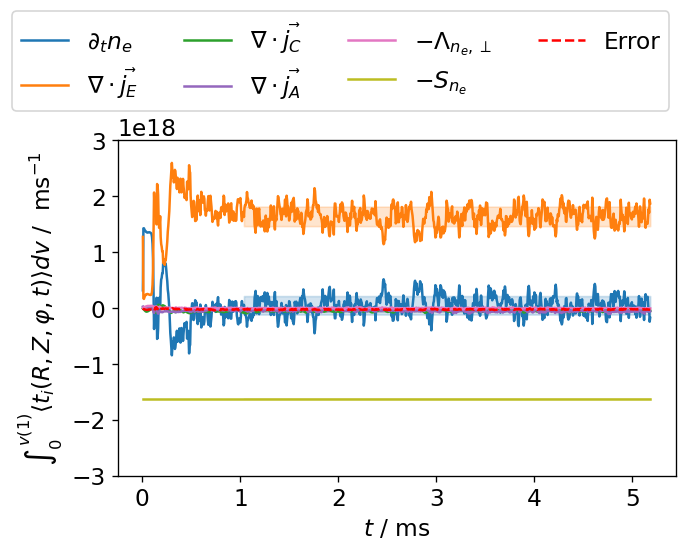

In [33]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    plot_series(to_plot_ne,ax,tau,res,start_idx=1)
    #     ax.set_yscale("linear")
    fmt = tck.ScalarFormatter()
    fmt.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(fmt)
    plt.ylim([-3e18,3e18])
    plt.legend(bbox_to_anchor=(0.40,1.42), ncol=4,loc='upper center')
    plt.savefig( 'new-ne-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

tau =  0


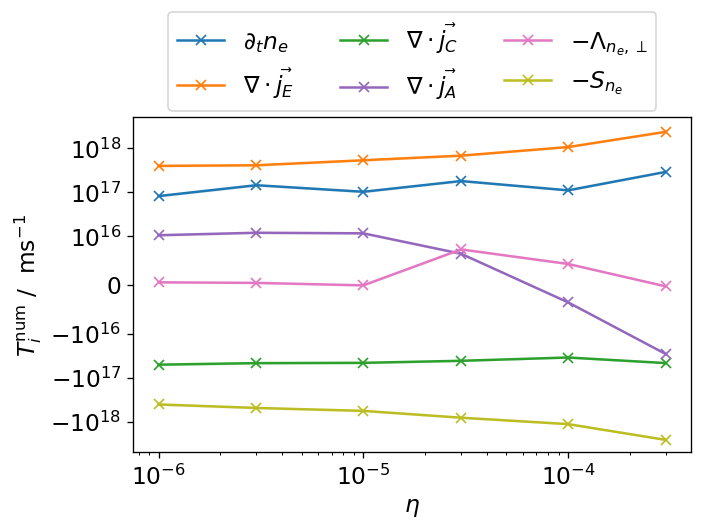

tau =  1


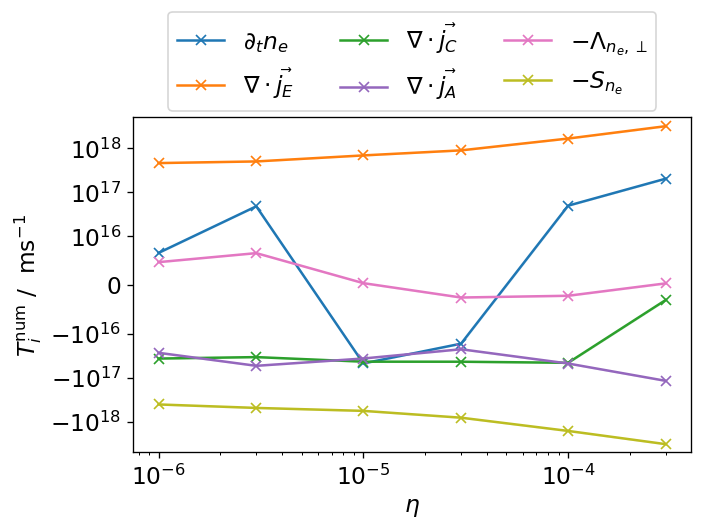

In [34]:
for tau in [0,1]:
    print("tau = ", tau)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_ne,ax,tau,'symlog')
    plt.yscale("symlog", linthresh = 1e16 )
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
    plt.ylim([-5e18,5e18])
    plt.savefig( 'new-ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()


In [35]:
to_plot_ni = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds, "ms"],
    "yscale" : [density, " ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["ions_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_i$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divcurvni_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
        "names" : ['divniA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 3,
        "label" :  r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnipar_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "color": 4,
#         "label" :  r"$\nabla \cdot \vec{ j_\parallel}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lniperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "color": 5,
#         "label" :  r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lniparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "color": 6,
#         "label" :  r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sni_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 7,
        "label" :  r"$S_{N_i}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot_ni, content)


Mean error is  31.274909025631693  std error is  42.47044294160188


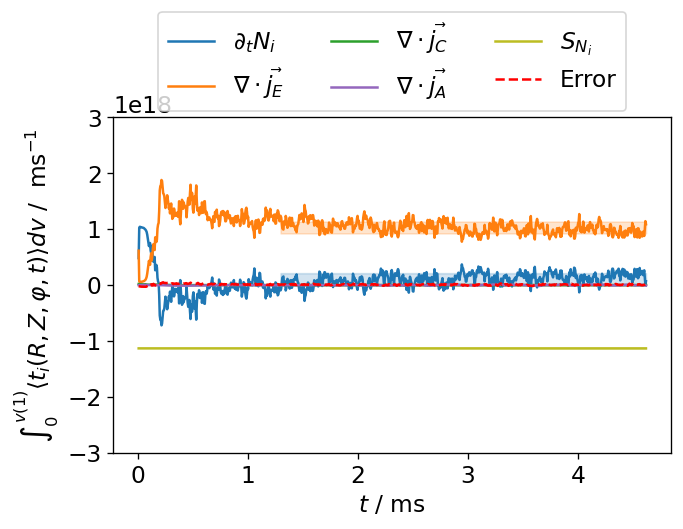

Mean error is  -79.77929371457468  std error is  44.95130394359636


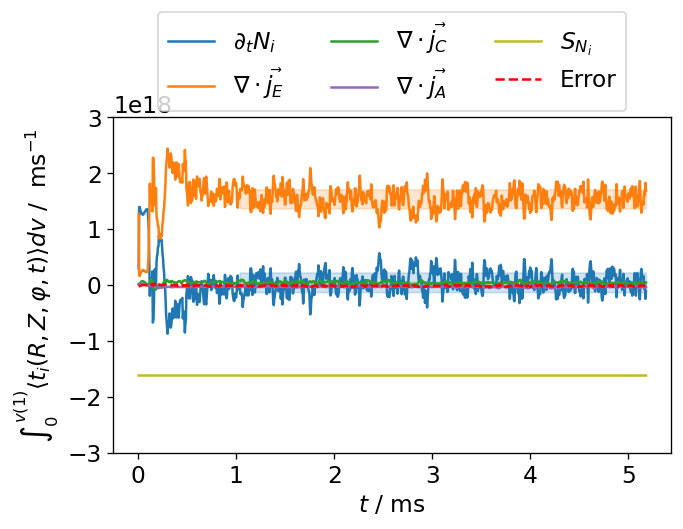

In [36]:
from matplotlib import ticker
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     tau = 1
    res = 1e-4
    plot_series(to_plot_ni,ax,tau,res,start_idx=1)
    #     ax.set_yscale("linear")
    plt.ylim([-3e18,3e18])
    fmt = ticker.ScalarFormatter()
    fmt.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(fmt)
    
    plt.legend(bbox_to_anchor=(0.5,1.35), ncol=3,loc='upper center')
    plt.savefig( 'new-ni-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

tau =  0


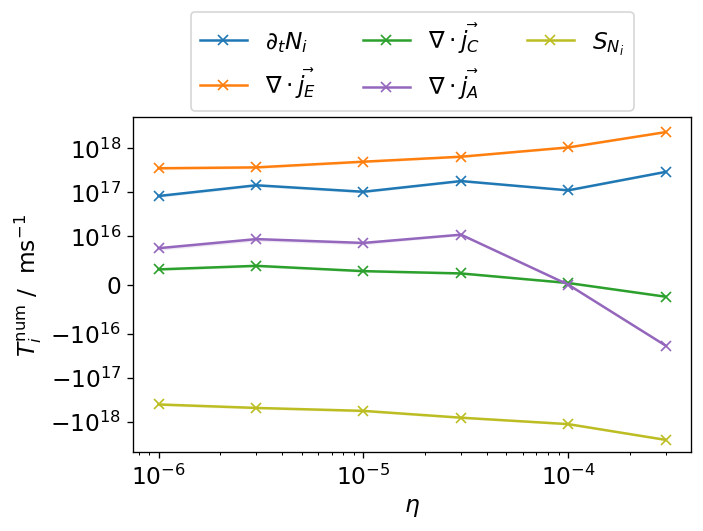

tau =  1


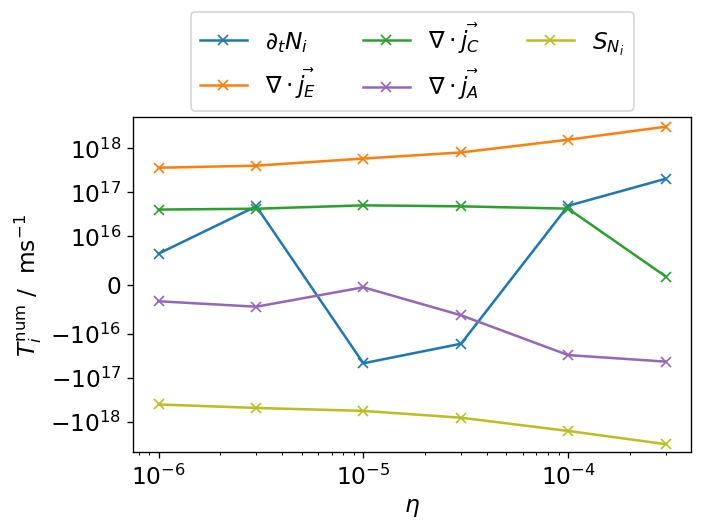

In [37]:
for tau in [0,1]:
    print("tau = ", tau)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_ni,ax,tau,'symlog')
    plt.yscale("symlog", linthresh = 1e16)
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
    plt.ylim([-5e18,5e18])
    plt.savefig( 'new-ni-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()


In [61]:
def energy(params):
    return 1./fp.omega_0_inv(**params)*fp.rho_s(**params)**3*1e19/1e3*params["T_e"]


In [39]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [energy, "eV ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : [True,True,True,True,True,True], "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divee_tt_ifs_lcfs','divei_tt_ifs_lcfs','diveea_tt_ifs_lcfs','diveia_tt_ifs_lcfs'],
        "derive" : [False,False,False,False], "signs" : [+1,1,1,1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_{E}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 2,
        "label" :  r"$-\Lambda_{E, \perp}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$-\Lambda_{E, \parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$-S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [-1],
        "color": 8,
        "label" :  r"$-R_{E}$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}

make_to_plot(to_plot_energy,content)

Mean error is  183.22349903113738  std error is  256.6592055255194


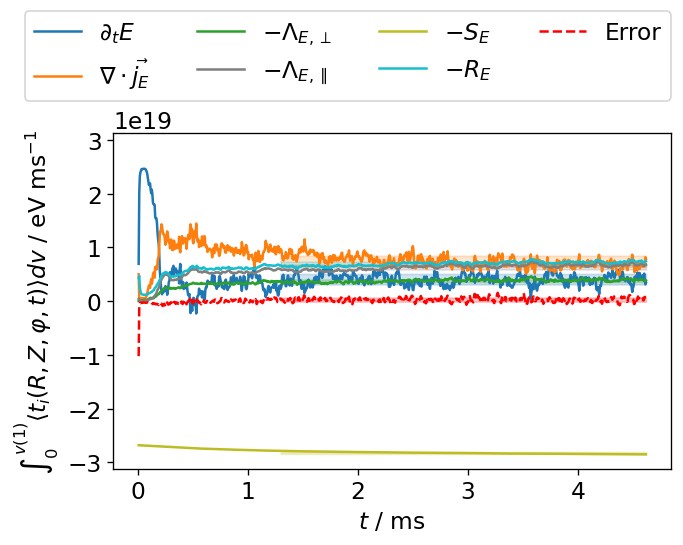

Mean error is  -275.7764096030248  std error is  446.8403076180076


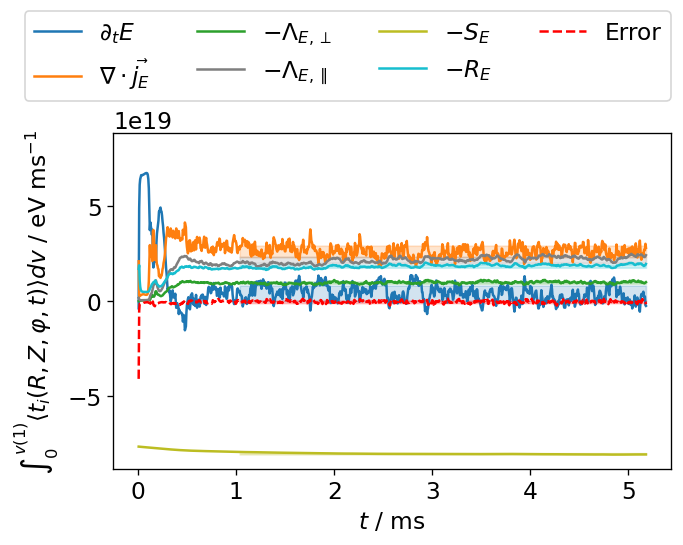

In [40]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    fmt = ticker.ScalarFormatter()
    fmt.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(fmt)
    plot_series(to_plot_energy,ax,tau,res,start_idx=1)

    plt.legend(bbox_to_anchor=(0.42,1.4),ncol = 4, loc = 'upper center')
    plt.savefig( 'new-energy-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

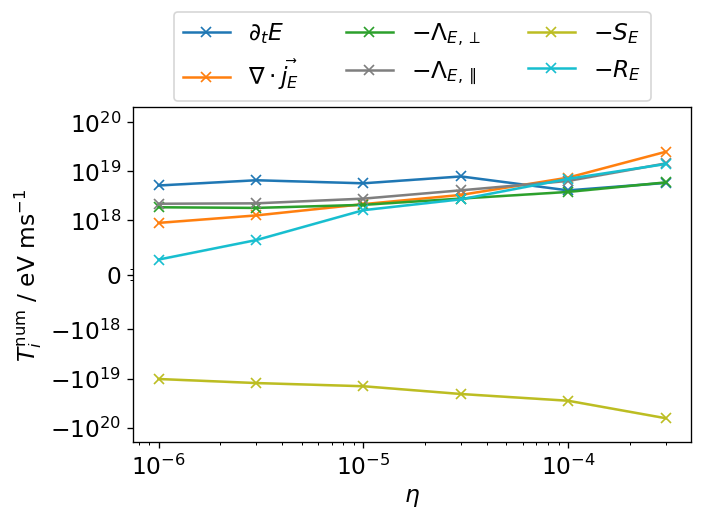

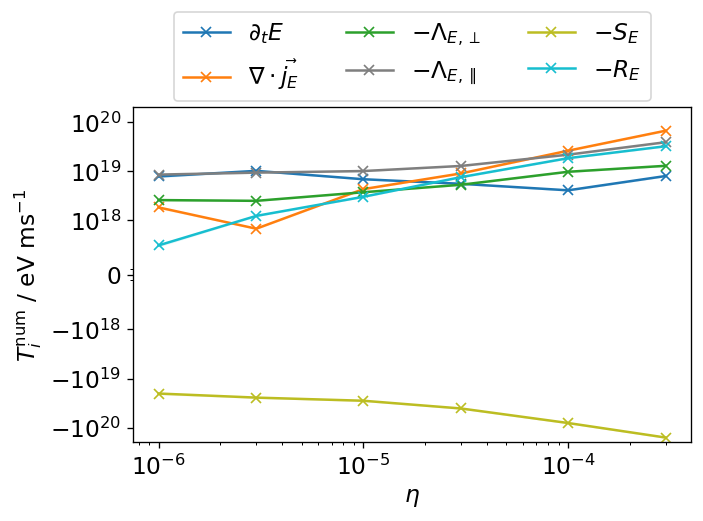

In [41]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau,'symlog')
#     ax.set_yscale("linear")
    plt.legend(bbox_to_anchor=(0.5,1.32),ncol = 3, loc = 'upper center')
    plt.yscale("symlog",  linthresh=1e18 )
    plt.ylim([-2e20,2e20])
    plt.yticks([-1e20,-1e19,-1e18,0,1e18, 1e19,1e20])
    plt.savefig( 'new-energy-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

## Ion parallel momentum

In [64]:
def momentum(params):
    return 1./fp.omega_0_inv(**params)*params['m_i']*1e19*fp.c_s(**params)*fp.rho_s(**params)**3



In [114]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [momentum, "kg m/s ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divparexbii_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_E})$",
        "vals": {0:dict(),1:dict()},
    },
    { # not so important
        "names" : ['divparApari_tt_ifs_lcfs','divpardiai_tt_ifs_lcfs','divparkappai_tt_ifs_lcfs'],
        "derive" : [False,False,False], "signs" : [1,1,1],
        "color": 2,
        "label" : r"$\nabla\cdot(\vec{j_A}+\vec{j_C}+\vec{j_k})$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : [],
#         "derive" : [False], "signs" : [1],
#         "color": 3,
#         "label" : r"$\nabla\cdot()$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['divparkappai_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 3,
#         "label" : r"$\nabla\cdot(\vec{j_k})$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ["sparmirrori_tt_ifs_lcfs","sparmirrorAi_tt_ifs_lcfs"],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 4,
        "label" : r"$(\nabla_\parallel+\vec b_\perp \cdot \nabla) N_i$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ["sparKappaphii_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 0,
#         "label" : r"$K_k \psi$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ["sparmirrorAi_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 4,
#         "label" : r"$\nabla_\parallel(b N_i)$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ["sparmirrorAi_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 4,
#         "label" : r"$\nabla_{A,\parallel}(N_i)$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # not so important
#         "names" : ["divjpari_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [1],
#         "color": 3,
#         "label" : r"$\nabla j_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ["lparperp_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 5,
#         "label" : r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ["lparpar_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 6,
#         "label" : r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    
    { # SPLIT UP WE HAVE BETTER CONSERVATION
        "names" : ['sparphiAi_tt_ifs_lcfs',"sparKappaphii_tt_ifs_lcfs"],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 5,
        "label" : r"$ N_i(\vec b_\perp  + U_\parallel K_\kappa ) \cdot \nabla\psi$",
        "vals": {0:dict(),1:dict()},
    },
    { 
        "names" : ['spardotAi_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [-1],
        "color": 6,
        "label" : r"$N_i\partial_t A$",
        "vals": {0:dict(),1:dict()},
    },
    { # largest term with friction
        "names" : ['sparphii_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [-1],
        "color": 7,
        "label" : r"$N_i\nabla_\parallel\psi$",
        "vals": {0:dict(),1:dict()},
    },
    { # largest term with sparphii
        "names" : ['friction_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 8,
        "label" : r"$-R_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
        
        
#     { # MOSTLY ADDS UP TO ZERO
#         "names" : ['sparphiAi_tt_ifs_lcfs','spardotAi_tt_ifs_lcfs','sparphii_tt_ifs_lcfs'],
#         "derive" : [False,False,False], "signs" : [-1,-1,-1], 
#         "color": 7,
#         "label" : r"$E$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # SAME AS ABOVE (cf last test)
#         "names" : ['sparmirrore_tt_ifs_lcfs','sparmirrorAe_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [-1,-1],
#         "color": 8,
#         "label" : r"$Mirror_e$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}

make_to_plot(to_plot_momentum, content)

tau =  0
Mean error is  -90.6487145273335  std error is  22.15467097505299


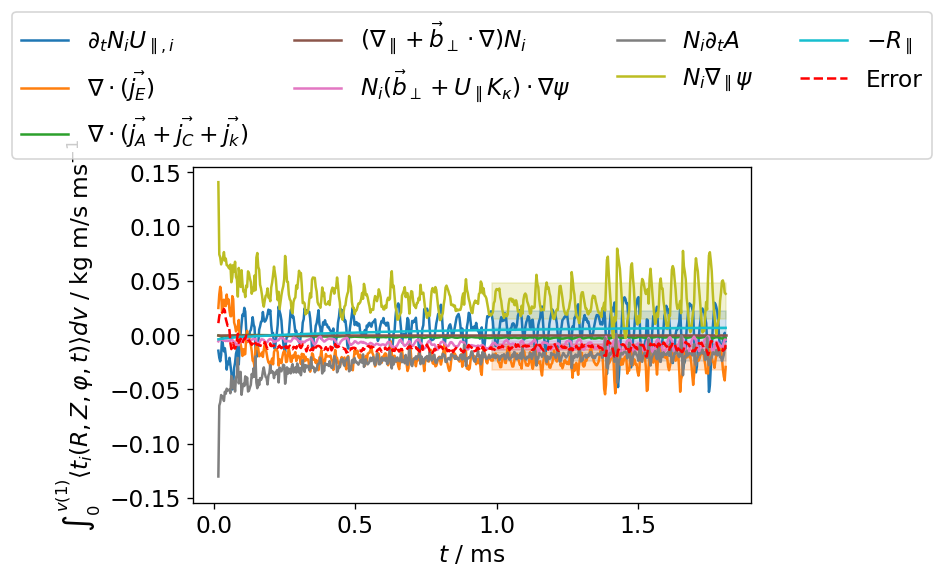

tau =  1
Mean error is  114.45909413351411  std error is  30.87909619659409


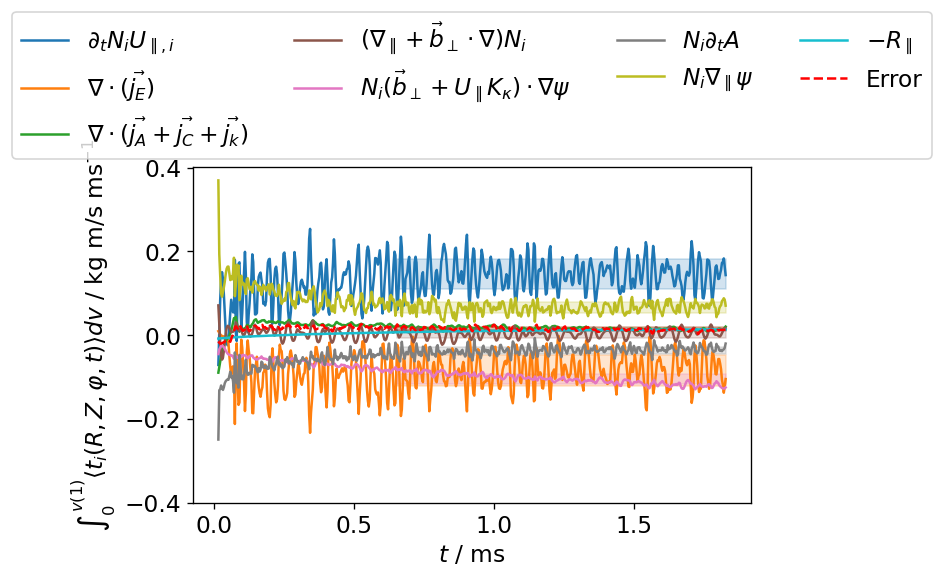

In [115]:


for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    print("tau = ", tau)
    res = 1e-6
    plot_series(to_plot_momentum,ax,tau,res,start_idx=5)
    plt.legend(bbox_to_anchor=(0.5,1.5),ncol = 4, loc = 'upper center')
    
    plt.savefig( 'new-niui-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
#     plt.xlim([8.2e4,8.6e4])
    plt.show()

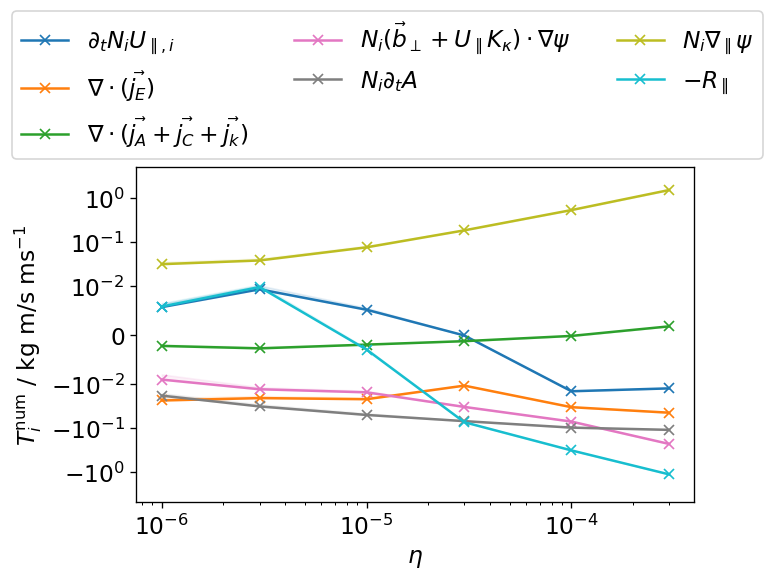

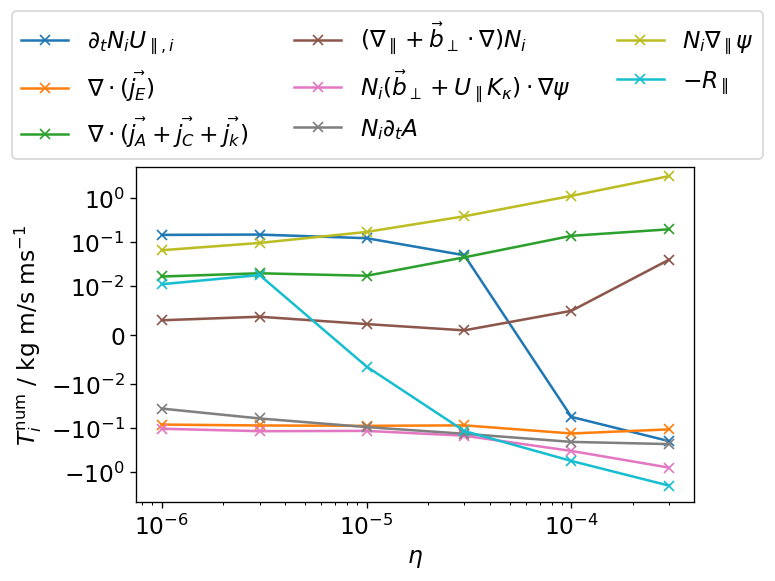

In [116]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_momentum,ax,tau,'symlog')
#     plot_relative(to_plot_momentum,ax,tau,'symlog')
#     plt.yscale("symlog",linthresh=100)
    plt.legend(bbox_to_anchor=(0.45,1.5),ncol = 3, loc = 'upper center')
#     plt.ylim([-5e4,5e4])
    plt.yscale("symlog",  linthresh=0.01 )
    plt.ylim([-5,5])
#     plt.yticks([-1e20,-1e19,-1e18,0,1e18, 1e19,1e20])
    plt.savefig( 'new-niui-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

## Parallel electron force balance

In [117]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [momentum, "kg m/s ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['friction_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 2,
        "label" : r"$\eta$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphie_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 8,
        "label" : r"$n_e\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot_electron_force,content)

tau =  0
Mean error is  0.13583996038192328  std error is  1.2621599799651237


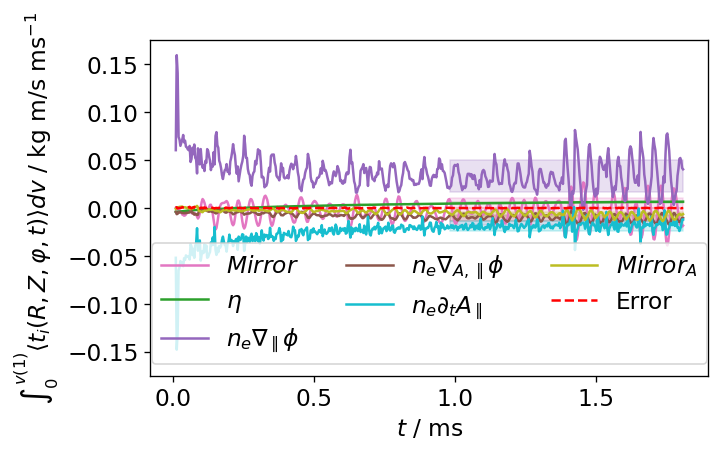

tau =  1
Mean error is  16.52365767234606  std error is  7.46584997679015


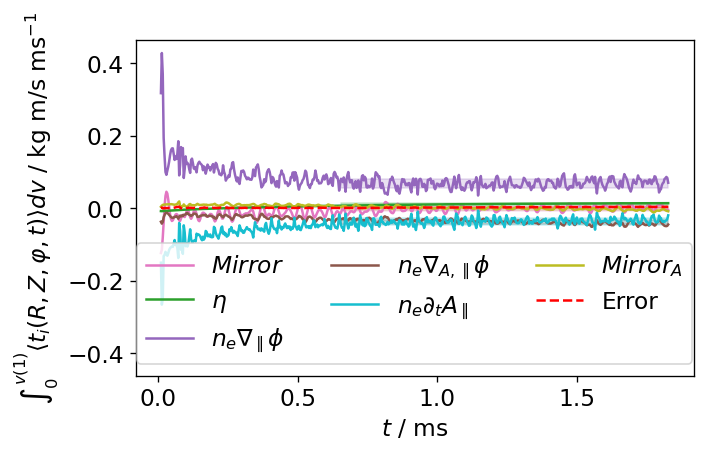

In [118]:

for tau in [0,1]:
    print( "tau = ", tau)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-6
    plot_series(to_plot_electron_force,ax,tau,res,start_idx=3)
    low, high = ax.get_ylim()
    bound = 4000# max(abs(low), abs(high))
    # ax.set_ylim(-bound, bound)
    # ax.set_xlim(1000,100000)
    plt.legend(ncol = 3, loc='lower center')
    plt.savefig( 'new-ue-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

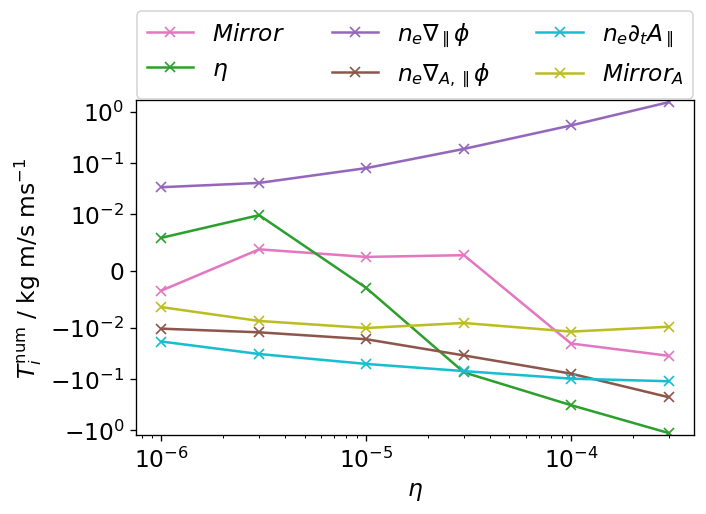

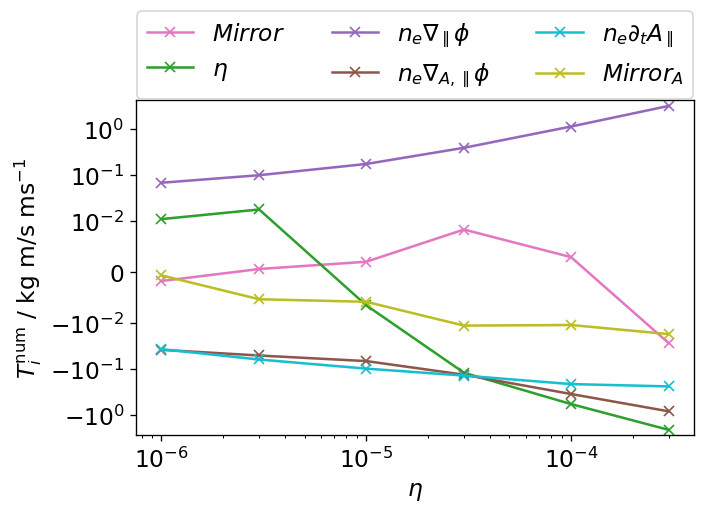

In [119]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_electron_force,ax,tau,'symlog')
    ax.set_yscale("symlog", linthresh=0.01)
    plt.legend(bbox_to_anchor=(0.5,1.3),ncol = 3, loc = 'upper center')
#     plt.ylim([1e-4,1])
    plt.savefig( 'new-ue-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [120]:
### TEST if ion and electron force terms are small against the parallel pressure gradient
to_plot_electron_force_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [momentum, "eV ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    { # MOSTLY ADDS UP TO ZERO
        "names" : ['sparphiAi_tt_ifs_lcfs','spardotAi_tt_ifs_lcfs','sparphii_tt_ifs_lcfs','friction_tt_ifs_lcfs'],
        "derive" : [False,False,False,False], "signs" : [-1,-1,-1,+1],
        "color": 7,
        "label" : r"$\Sigma F$",
        "vals": {0:dict(),1:dict()},
    },
    { # MOSTLY ADDS UP TO ZERO
        "names" : ['sparmirrore_tt_ifs_lcfs','sparmirrorAe_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 8,
        "label" : r"$Mirror_e$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['sparmirrore_tt_ifs_lcfs','sparmirrorAe_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [1,1],
#         "color": 5,
#         "label" : r"$Mirror_e$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['friction_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [-1],
#         "color": 2,
#         "label" : r"$\eta$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['sparphii_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 3,
#         "label" : r"$\delta N\nabla_\parallel\phi $",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['sparphiAi_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [-1],
#         "color": 4,
#         "label" : r"$\delta N \nabla_{A,\parallel}\phi$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['spardotAi_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 8,
#         "label" : r"$\delta N\partial_t A_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
#     { # it works better without ...
#         "names" : ['sparmirrorAi_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [+1],
#         "color": 7,
#         "label" : r"$Mirror_A$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}
make_to_plot(to_plot_electron_force_diff,content)

Mean error is  -16.080808056285953  std error is  6.82693561065346


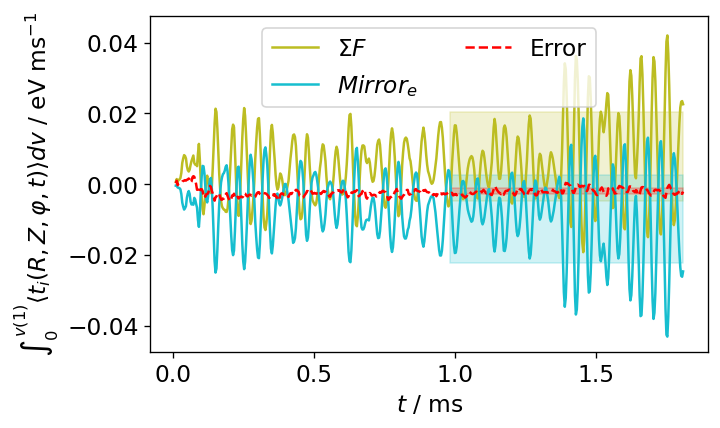

Mean error is  -4.925185408639595  std error is  15.620706512631125


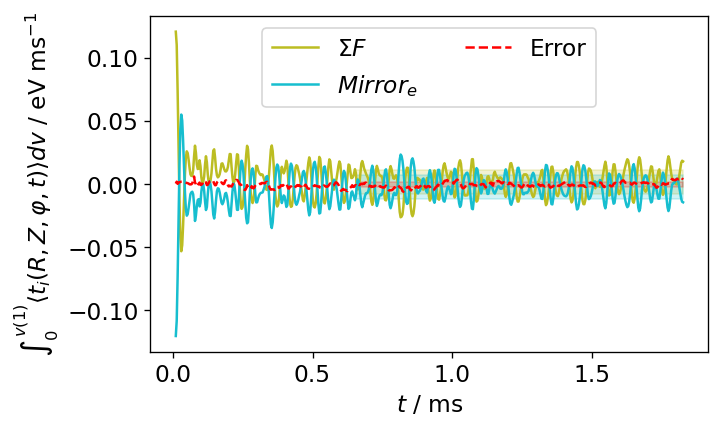

In [121]:

for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     tau = 1
    res = 1e-6
    plot_series(to_plot_electron_force_diff,ax,tau,res,start_idx=3)
    low, high = ax.get_ylim()
    bound = 4000# max(abs(low), abs(high))
    # ax.set_ylim(-bound, bound)
    # ax.set_xlim(1000,100000)
    plt.legend(ncol = 2, loc='upper center')
    plt.show()

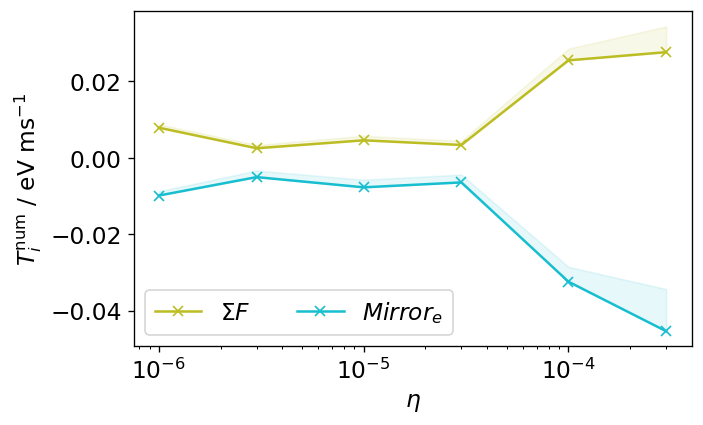

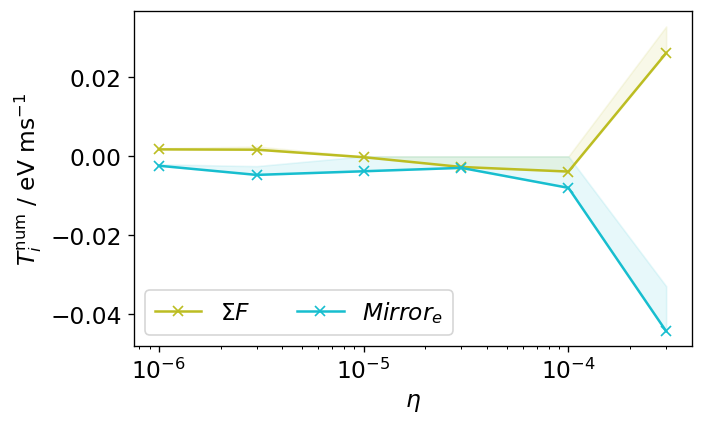

In [122]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_electron_force_diff,ax,tau,'symlog')
    plt.yscale("linear")
    plt.legend(ncol=3, loc = 'lower left')
#     plt.ylim([1e-4,1])
    plt.show()

In [123]:
to_plot_angular_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [energy, "eV ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["niuibphi_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}R$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divparbphiexbi_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_E})$",
        "vals": {0:dict(),1:dict()},
    },
    { # not so important
        "names" : ['divparbphiApar_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [-1],
        "color": 2,
        "label" : r"$\nabla\cdot(\vec{j_A})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divparbphidiai_tt_ifs_lcfs','divparbphikappai_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 3,
        "label" : r"$\nabla\cdot(\vec{j_C})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['socurve_tt_ifs_lcfs','socurvi_tt_ifs_lcfs',
                   'socurvkappae_tt_ifs_lcfs','socurvkappai_tt_ifs_lcfs'], 
        "derive" : [False,False,False,False], "signs" : [543,543,543,543], # one R_0 has to be multiplied
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ["lparperpbphi_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 5,
#         "label" : r"$\Delta_\perp$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ["lparparbphi_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [-1],
#         "color": 6,
#         "label" : r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}

make_to_plot(to_plot_angular_momentum,content)


Mean error is  -46546.09019342587  std error is  23829.313273221705


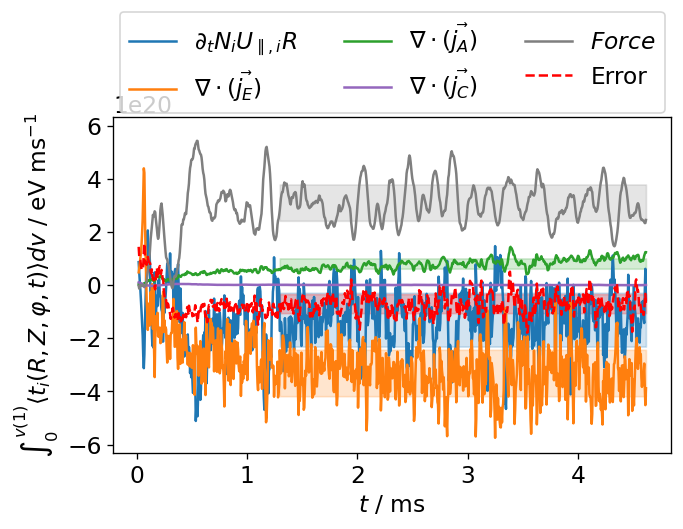

Mean error is  -387592.4977293747  std error is  97096.86383288798


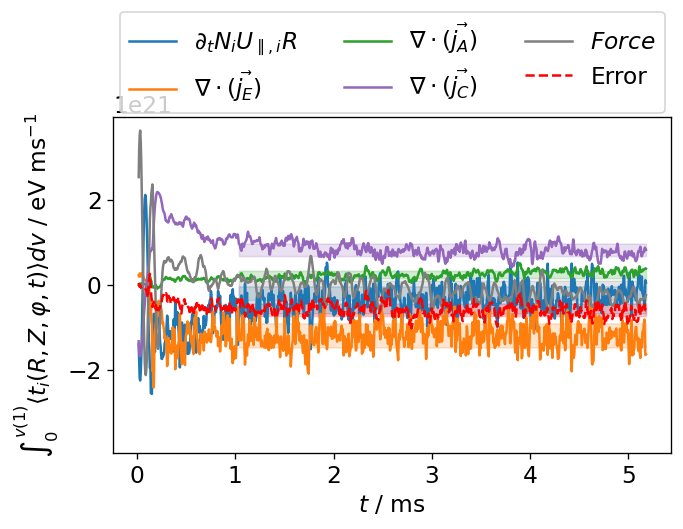

In [124]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     tau = 1
    res = 1e-4
    plot_series(to_plot_angular_momentum,ax,tau,res,start_idx=3)
    low, high = ax.get_ylim()
#     ax.set_ylim(-1e6, 1e6)
    # ax.set_xlim(1000,100000)
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
    plt.savefig( 'new-niuibphi-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

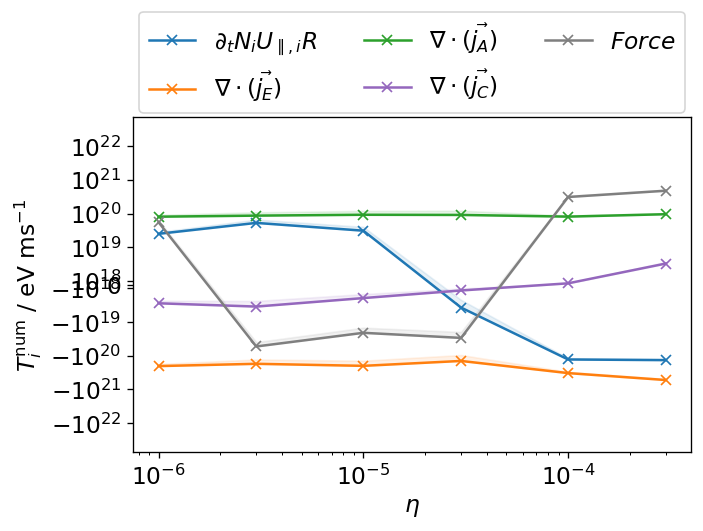

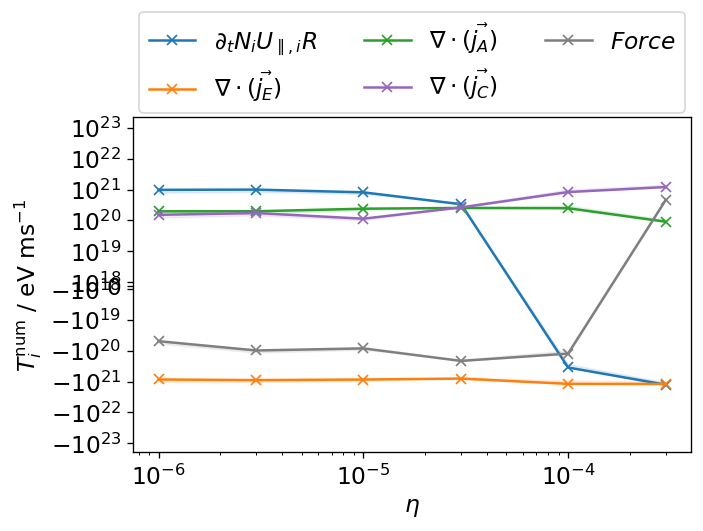

In [125]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_angular_momentum,ax,tau,'symlog')
    ax.set_yscale("symlog", linthresh=1e19)
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
#     plt.ylim([1e-4,1])
    plt.savefig( 'new-niuibphi-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [128]:
# plot relative errors in one plot
# to_plot_dict = dict()
# { 
#     'label' : "",
#     'color' : 0,
#     'to_plot' : {}
# }
def plot_relative_error( to_plot_dict_list, ax, tau, style):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    for to_plot_dict in to_plot_dict_list:
        to_plot = to_plot_dict["to_plot"]
        resistivities = np.array(sorted(to_plot["res"][tau]))
        size = resistivities.size
        mean=dict()
        std = dict()

        for field in to_plot["fields"]:
            mean[field["label"]]=np.zeros(size)
            std[field["label"]]=np.zeros(size)
            for i in np.arange(0,size,1):  
                min_idx = min_idx_dict[tau][resistivities[i]]
                mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
                std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
    #         print( "Averages ", field["label"], " is ", mean[field["label"]])
        error = list()
        mean_error = np.zeros(size)
        std_error = np.zeros(size)
        for i in np.arange(0,size,1):   
            min_idx = min_idx_dict[tau][resistivities[i]]
            error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
            for field in to_plot["fields"]:
                error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
            mean_error[i] = error[i].mean()
            std_error[i] = error[i].std()

        summe_ohne_fehler = np.zeros(size)
        for field in to_plot["fields"]:
            summe_ohne_fehler += np.abs(mean[field["label"]])
        if style == "log":  
            ax.plot( resistivities, np.abs(mean_error)/summe_ohne_fehler,
                    marker='x', ls='-',
                    label=to_plot_dict['label'],
                    color = colors[to_plot_dict['color']]
                   )
            ax.set_yscale('log')
        if style == "symlog":
            ax.plot( resistivities, (mean_error)/summe_ohne_fehler,
                    marker='x', ls='-',
                    label=to_plot_dict['label'],
                    color = colors[to_plot_dict['color']]
                   )
            
            ax.set_yscale('symlog')
    ax.set_ylabel(r'$E$ / $\sum_i |T^{num}_i|$') 
    ax.set_xlabel(r'$\eta$')
    ax.set_xscale('log')    

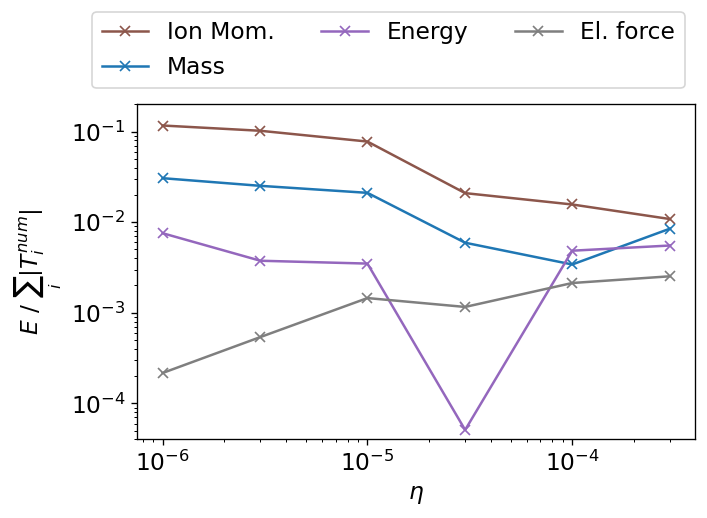

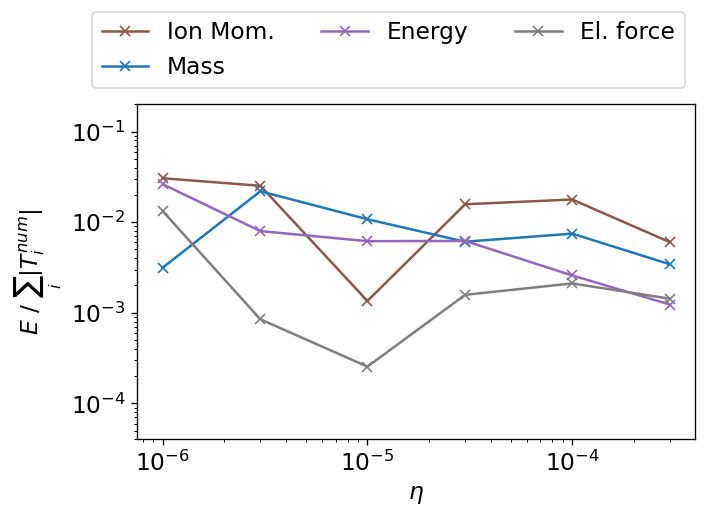

In [131]:
to_plot_dict_list = [
#     {
#         'label' : "Vorticity (LWL)",
#         'color' : 2,
#         'to_plot' : to_plot_vorticity
        
#     },
#     {
#         'label' : "Ang. Mom. (LWL)",
#         'color' : 5,
#         'to_plot' : to_plot_angular_momentum
        
#     },
    {
        'label' : "Ion Mom.",
        'color' : 4,
        'to_plot' : to_plot_momentum
        
    },
    {
        'label' : "Mass",
        'color' : 0,
        'to_plot' : to_plot_ne
        
    },
#     {
#         'label' : "gy Mass",
#         'color' : 1,
#         'to_plot' : to_plot_ni
        
#     },
    {
        'label' : "Energy",
        'color' : 3,
        'to_plot' : to_plot_energy
        
    },    

    {
        'label' : "El. force",
        'color' : 6,
        'to_plot' : to_plot_electron_force
        
    },


]
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative_error(to_plot_dict_list,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(bbox_to_anchor=(0.45,1.31), ncol=3, loc = 'upper center')
    plt.ylim([4e-5,2e-1])
    plt.savefig( 'new-relative-errors-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [59]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "timescale" : [milliseconds,"ms"],
    "yscale": [mass, "eV ms"+r"$^{-1}$"],
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : [True,True], "signs" : [+1,-1],
#         "names" : ["ions_ifs_lcfs"], "derive" : [True], "signs" : [-1],
        "color": 0,
        "label" : r"$\partial_t (n_e-N_i)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs',
                   'divcurvne_tt_ifs_lcfs','divcurvni_tt_ifs_lcfs' ],
        "derive" : [False,False,False,False], "signs" : [+1,-1,+1,-1],
        "color":3,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "names" : ['divneE_tt_ifs_lcfs','divniE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "names" : ['divneA_tt_ifs_lcfs','divniA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    { 
        "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,+1],
        "color": 4,
        "label" : r"$-\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [+1,-1],
#         "color": 5,
#         "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [-1,+1],
#         "color": 6,
#         "label" : r"$\Delta_\parallel$",
#         "vals": {0:dict(),1:dict()},
#     },


        #     { # 1e-6 for both 
#         "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
#         "color": 7,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },

    ]
}
make_to_plot(to_plot_mass_diff,content)


NameError: name 'mass' is not defined

In [ ]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    plot_series(to_plot_mass_diff,ax,tau,res,start_idx=10)
#     plt.xlim([5e4,5.5e4])
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
    plt.savefig( 'new-neni-diff-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()


In [ ]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'symlog')
    plt.legend(bbox_to_anchor=(0.5,1.35),ncol = 3, loc = 'upper center')
#     plt.yscale("symlog",linthresh=10)
#     plt.ylim([-1e3,1e3])
    plt.savefig( 'new-neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

### Vorticity accuracy on LCFS

In [ ]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ['oexbi_fsa'], "idx": idx, # wrong 
#         "names" : ['oexbe_ifs_lcfs'],  # total vorticity conservation is very bad (small terms)
        "derive" : [True],"signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E )$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divoexbi_tt_fsa'],"idx" : idx, # 
#         "names" : ['divoexbe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{j_\Omega,E}$",
        "vals": {0:dict(),1:dict()},
    },    
    {
        "names" : ['divoexbiUD_tt_fsa'], "idx": idx,
#         "names" : ['divoexbeUD_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_\Omega,D}$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['divoApar_tt_fsa'], "idx" : idx,
#         "names" : ['divoApar_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 8,
        "label" : r"$Maxwell$",
        "vals": {0:dict(),1:dict()},
    },
#     {
# #         "names" : ['jvoexbApar_tt_ifs'],
#         "names" : ['jvodiaApar_tt_ifs'],
#         "idx": idx,"derive" : False, "signs" : [+1],
#         "color": 9,
#         "label" : r"$\nabla\cdot\vec{ j_{\Omega,D,A}}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['loexbe_tt_fsa'], "idx" : idx, 
#         "names" : ['loexbe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [-1],
        "color": 1,
        "label" :  r"$\Lambda$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['socurve_tt_fsa','socurvi_tt_fsa',
                   'socurvkappae_tt_fsa','socurvkappai_tt_fsa'], "idx" : idx,
#         "names" : ['socurve_tt_ifs_lcfs','socurvi_tt_ifs_lcfs',
#                    'socurvkappae_tt_ifs_lcfs','socurvkappai_tt_ifs_lcfs'],
        "derive" : [False,False,False,False], "signs" : [-1,-1,-1,-1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sosne_tt_fsa', 'sospi_tt_fsa'], "idx" : idx,
#         "names" : ['sosne_tt_ifs_lcfs', 'sospi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}
make_to_plot(to_plot_vorticity,contentdiag)

In [ ]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    plot_series(to_plot_vorticity,ax,tau,res)
    plt.legend(bbox_to_anchor=(1.02, 1.0), ncol=1, loc='upper left')
    plt.savefig( 'new-omega_E-conservation-lcfs-'+str(tau)+str(res)+'.png',bbox_inches='tight')
    plt.show()

In [ ]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau,'symlog')
#     plt.yscale("symlog",linthresh=1e-5)
    plt.yscale("linear")
#     plt.legend()
    plt.legend(bbox_to_anchor=(1.02, 1.0), ncol=1, loc='upper left'#, bbox_to_anchor=(0.5, 1.05),
         )#, fancybox=True, shadow=True)
    ax.set_ylim([-2e-5,2e-5])
    plt.savefig( 'new-omega_E-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [ ]:
### THE TERMS IN THE COCE CONSERVATION
to_plot_coce = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    { # n_e - N_i
        "names" : ["v_Omega_E_gf_ifs_lcfs", "laplace_ni_ifs_lcfs"], "derive" : [True,True], "signs" : [+1,+1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E + \Omega_D)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_E_main_gf_tt_ifs_lcfs','v_adv_E_rest_gf_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_D_main_gf_tt_ifs_lcfs','v_adv_D_rest_gf_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_D}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_mag_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_{mag}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_bperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 4,
        "label" : r"$\nabla\cdot\vec{ j_{\perp}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs',
                   'divcurvne_tt_ifs_lcfs','divcurvni_tt_ifs_lcfs' ],
        "derive" : [False,False,False,False], "signs" : [+1,-1,+1,-1],
        "color":5,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divjnipar_tt_ifs_lcfs','divjnepar_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
        "color": 6,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    { 
        "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,+1],
        "color": 7,
        "label" : r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,+1],
        "color": 8,
        "label" : r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },


    ]
}

In [ ]:
import copy
for tau in [0,1]:
    temp = copy.deepcopy(to_plot_coce)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    print("Tau = ",tau)

    content_nn = contentdiag
    if tau == 0:
        temp['fields'][0]['signs'] = [+1,0] # Laplace has a tau
        temp['fields'][2]['signs'] = [0] # j_D has a sign error
    make_to_plot(temp,content_nn)
    plot_series(temp,ax,tau,res)

    plt.legend(bbox_to_anchor=(-0.2, 1.5), ncol=4, loc='upper left')
    plt.show()


In [ ]:
make_to_plot(to_plot_coce,contentdiag)
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_coce,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(bbox_to_anchor=(-0.02,1.5), ncol=3,loc='upper left')


In [ ]:
# Check ExB advection terms in the COCE equations
for pp in contentdiag:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    print( "Tau = ", pp['physical']['tau'])
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
                                         -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
            label='divjE ')
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['v_adv_E_main_gf_tt_fsa'][-1,:]
                                        + pp['file']['v_adv_E_rest_gf_tt_fsa'][-1,:]
                                         )*pp['dvdpsi']).to_numpy(), grid),
            label='div O')
    ax.plot( pp['rho_p'], (pp['file']['divoexbi_tt_fsa'][-1,:])*pp['dvdpsi'],
            label='div OPsi')


    plt.legend()
    plt.show()

In [ ]:
# Check diamagnetic advection terms in the COCE equations
for pp in [contentdiag[0]]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    print( "Tau = ", pp['physical']['tau'])
#     ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
#                                          -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
#             label='divjE ')
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['v_adv_D_main_gf_tt_fsa'][-1,:]
                                        + pp['file']['v_adv_D_rest_gf_tt_fsa'][-1,:]
                                         )*pp['dvdpsi']).to_numpy(), grid),
            label='div O')
    ax.plot( pp['rho_p'], (pp['file']['divodiaiUE_tt_fsa'][-1,:])*pp['dvdpsi'],
            label='div OPsi')

    plt.ylim([-5e4,5e4])
    plt.legend()
    plt.show()